<!--Header-->
<div>
    <div class="row" style="color: #4D4D4D;font-size: 15px;padding-bottom: 20px">
        <div class="col-md-7">
            <img src="https://cv.uoc.edu/mc-icons/inici/logoUOC.png" alt="Logo UOC" class="img-responsive" style="margin:20px 0px 0px">
        </div>
        <div class="col-md-5">
            <h1 style="margin:15px 0px 0px;font-size: 40px;">Exemple complet de classificació</h1>
            <h2>Qui va sobreviure al Titanic?</h2>
            <div style="text-align:left;margin-top: 5px;"></div>
        </div>
    </div>
    <div class="row" style="background: #FCB517;padding: 10px 20px;">
        <div class="col-md-6">
            <div>PID_00233252</div>
        </div>
        <div class="col-md-6">
            <div style="text-align:right;">Autor: Xavier Duran Albareda <span style="margin-left: 30px;">Coordinació: Julià Minguillón</span></div>
        </div>
    </div>
</div>
<!--/Header-->

## Introducció ##

En aquesta activitat desenvoluparem un exemple complert de classificació amb el conjunt de dades corresponent a la competició [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) de [Kaggle](https://www.kaggle.com/).

![Titanic](images/titanic.jpg)

## Lectura del fitxer de dades

In [232]:
%matplotlib inline

import numpy as np
import pandas as pd
import re as re
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [233]:
df = pd.read_csv('data/titanic.csv', header = 0)

## Descripció de les dades

El nostre conjunt de dades té 12 columnes o variables, de les quals 3 (`Age`, `Cabin` i `Embarked`) tenen valors no disponibles. La variable que volem predir és `Survived`, que ens indica si el passatger va sobreviure a la tragèdia del Titanic.

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [235]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [236]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Visualització i transformació de les dades

El que farem ara serà analitzar variable per variable quines transformacions necessita per fer-la servir en la modelització de les dades.

### `PassengerId`

Identificador del passatger. És una variable numèrica correlativa, que no té cap valor predictiu. No la inclourem en el nostre model.

In [237]:
df['PassengerId'].head(10)

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: PassengerId, dtype: int64

In [238]:
df.drop(['PassengerId'], axis=1, inplace=True)

### `Survived`

Indica si el passatger va sobreviure (`1`) o no (`0`). Serà la nostra variable a predir. Veiem que hi ha al voltant d'un 38% de passatgers que van sobreviure.

<Axes: xlabel='Survived'>

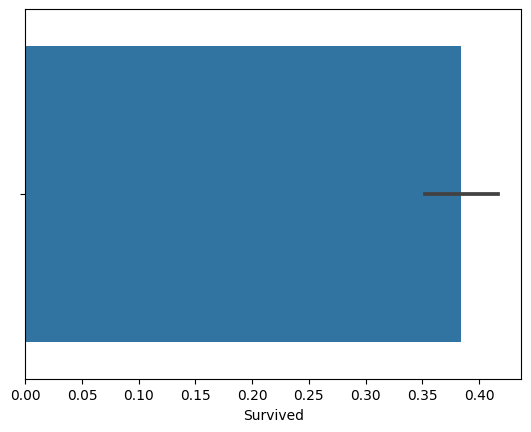

In [239]:
sns.barplot(x="Survived", data=df)

In [240]:
df.describe()['Survived']

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

### `Pclass`

Classe del tiquet. És una variable categòrica, amb 3 valors diferents corresponents a la primera, la segona i la tercera classe. Veiem que està correlacionada amb la supervivència: com més alta és la classe, més supervivents hi ha.

In [241]:
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


<Axes: xlabel='Pclass', ylabel='Survived'>

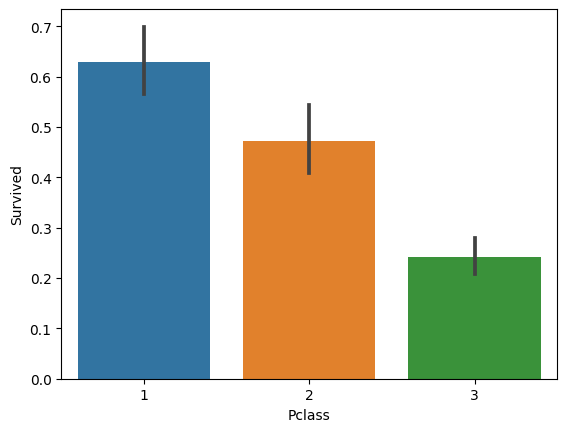

In [242]:
sns.barplot(x="Pclass", y="Survived", data=df)

### `Sex`

Sexe del passatger. És una variable categòrica amb dos valors, `male`i `female`. La convertirem a binària per fer l'anàlisi.

In [243]:
df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


<Axes: xlabel='Sex', ylabel='Survived'>

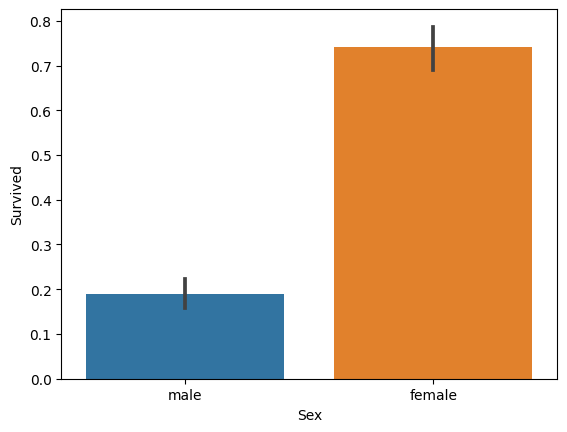

In [244]:
sns.barplot(x="Sex", y="Survived", data=df)

In [245]:
df['Sex'] = df['Sex'] == 'male'

### `SibSp`

Número de germans o cònjugues del passatger dins del Titanic. És una variable numèrica.

In [246]:
df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


<Axes: xlabel='SibSp', ylabel='Survived'>

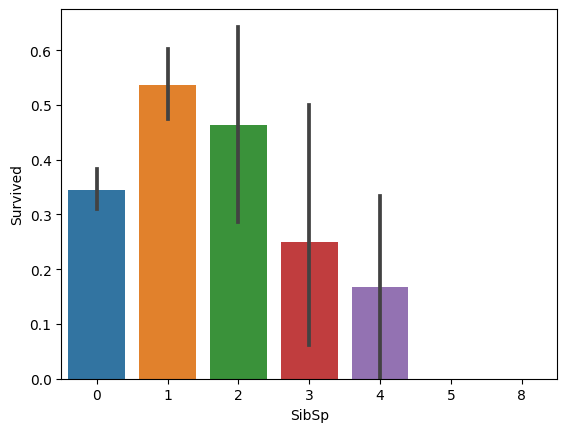

In [247]:
sns.barplot(x="SibSp", y="Survived", data=df)

### `Parch`

Nombre de pares i fills del passatger dins del Titanic. És una variable numèrica.

In [248]:
df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


<Axes: xlabel='Parch', ylabel='Survived'>

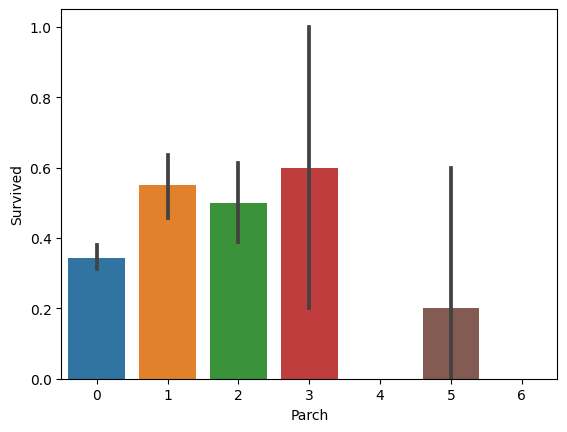

In [249]:
sns.barplot(x="Parch", y="Survived", data=df)

### `FamilySize`

Amb les variables `SibSp` i `Parch` podem calcular la mida de la família d'un passatger, que anomenarem `FamilySize`. Serà doncs, una variable numèrica.

In [250]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


<Axes: xlabel='FamilySize', ylabel='Survived'>

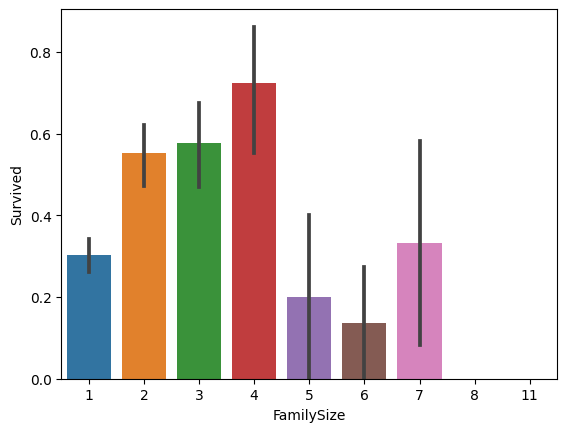

In [251]:
sns.barplot(x="FamilySize", y="Survived", data=df)

### `IsAlone`

Pot ser interessant caracteritzar si el pasatger no té família dins el Titanic. Calcularem la variable binària `IsAlone`.

In [252]:
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


<Axes: xlabel='IsAlone', ylabel='Survived'>

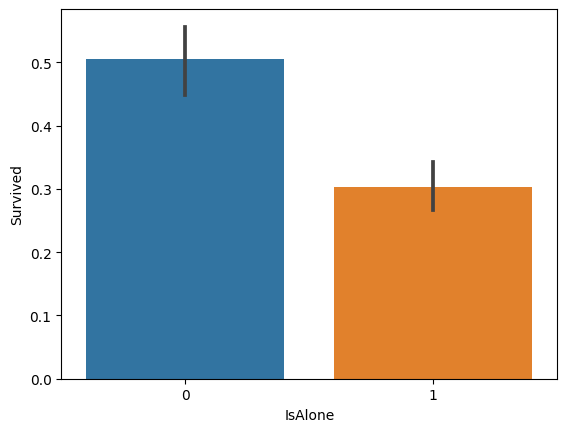

In [253]:
sns.barplot(x="IsAlone", y="Survived", data=df)

### `Ticket`

Número del tiquet del passatger. És alfanumèric i a priori no ofereix informació que ens pugui ajudar en el model predictiu. No la inclourem.

In [254]:
df.drop(['Ticket'], axis=1, inplace=True)

### `Embarked`

Indica el port d'embarcament del passatger. És una variable categòrica on `C` indica que va embarcar a Cherbourg, `Q` a Queenstown i `S` a Southampton.

In [255]:
df['Embarked'] = df['Embarked'].fillna('S')
df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


<Axes: xlabel='Embarked', ylabel='Survived'>

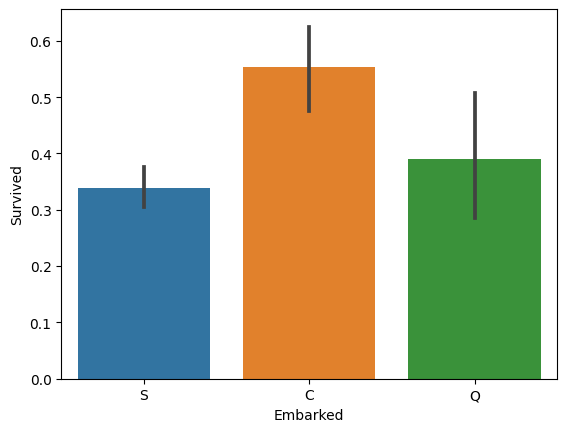

In [256]:
sns.barplot(x="Embarked", y="Survived", data=df)

### `Fare`

Indica el preu del passatge. És doncs, una variable numèrica contínua.

<Axes: xlabel='Fare', ylabel='Count'>

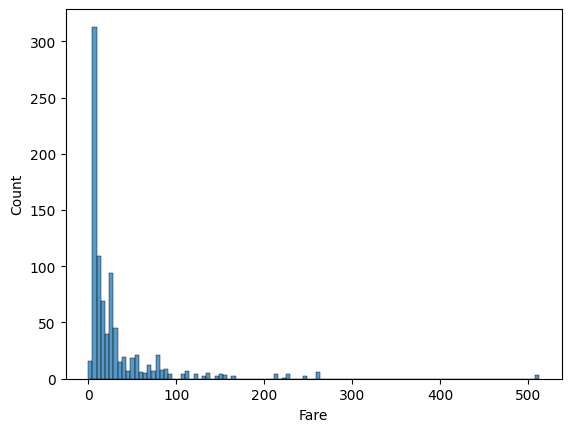

In [257]:
sns.histplot(df['Fare'])

Veiem que la variable no té una distribució normal. Aplicarem el logaritme per acostar-la a la normalitat.

<Axes: xlabel='Fare', ylabel='Count'>

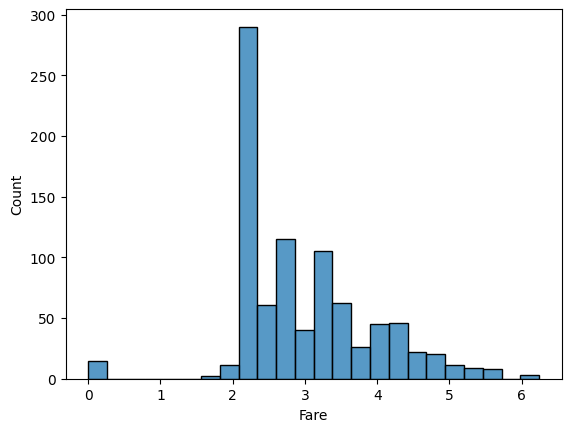

In [258]:
df['Fare'] = np.log1p(df['Fare'])
sns.histplot(df['Fare'])

Transformem la variable a categòrica.

In [259]:
df['FareGroup'] = pd.qcut(df['Fare'], 7, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
df[['FareGroup', 'Survived']].groupby(['FareGroup'], as_index=False).mean()

,FareGroup,Survived
0,A,0.207143
1,B,0.200000
2,C,0.316327
3,D,0.406250
4,E,0.445312
5,F,0.456000
6,G,0.685039


<Axes: xlabel='FareGroup', ylabel='Survived'>

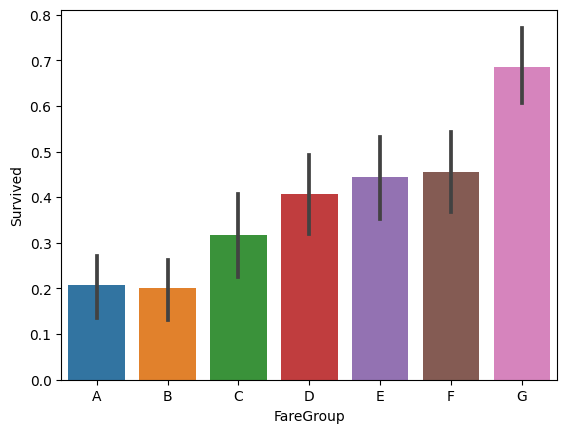

In [260]:
sns.barplot(x="FareGroup", y="Survived", data=df)

In [261]:
df.drop(['Fare'], axis=1, inplace=True)

## `Cabin`

Número de la cabina del passatger. És una variable de text, que indica quina a cabina estava el passatger. Transformarem la variable en una binària depenent si el passatger era en una cabina o no. 

In [262]:
df['InCabin'] = ~df['Cabin'].isnull()

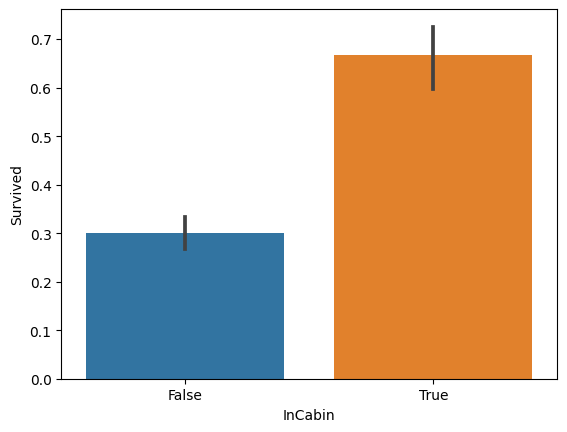

In [263]:
sns.barplot(x="InCabin", y="Survived", data=df)
plt.show()

In [264]:
df.drop(['Cabin'], axis=1, inplace=True)

### `Age`

Edat del passatger. És una variable numèrica que té bastants valors buits. Categoritzarem la variable en 8 categories segons l'edat que tingui. La categoria `Unknown` serà la d'aquells passatgers que no en tinguem l'edat.

In [265]:
df["Age"] = df["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
df['AgeGroup'] = pd.cut(df["Age"], bins, labels = labels)

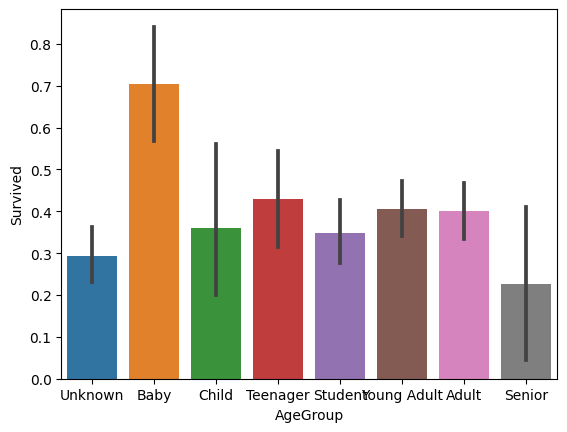

In [266]:
sns.barplot(x="AgeGroup", y="Survived", data=df)
plt.show()

In [267]:
df.drop(['Age'], axis=1, inplace=True)

### `Name`

Nom del passatger. D'aquesta variable en podem extreure els títols inclosos amb el nom, com `Mr`, `Miss` o `Master`, que poden tenir valor predictiu. La resta del nom, l'ignorarem.

In [268]:
df['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [269]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

df['Title'] = df['Name'].apply(get_title)

pd.crosstab(df['Title'], df['Sex'])

Sex,False,True
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Categoritzarem aquells títols que siguin més utilitzats, i la resta els agruparem a una categoria `Rare`.

In [270]:
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


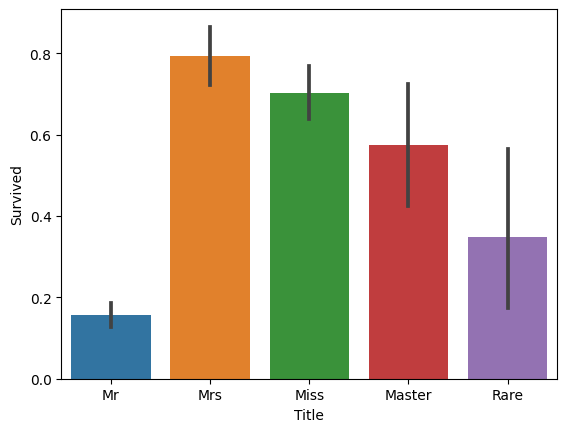

In [271]:
sns.barplot(x="Title", y="Survived", data=df)
plt.show()

In [272]:
df.drop(['Name'], axis=1, inplace=True)

## Correlació de les variables

Si visualitzem la matriu de correlació entre les variables, veiem que les més correlacionades amb la que volem preidr són `Sex`, `Pclass` i `isAlone`.

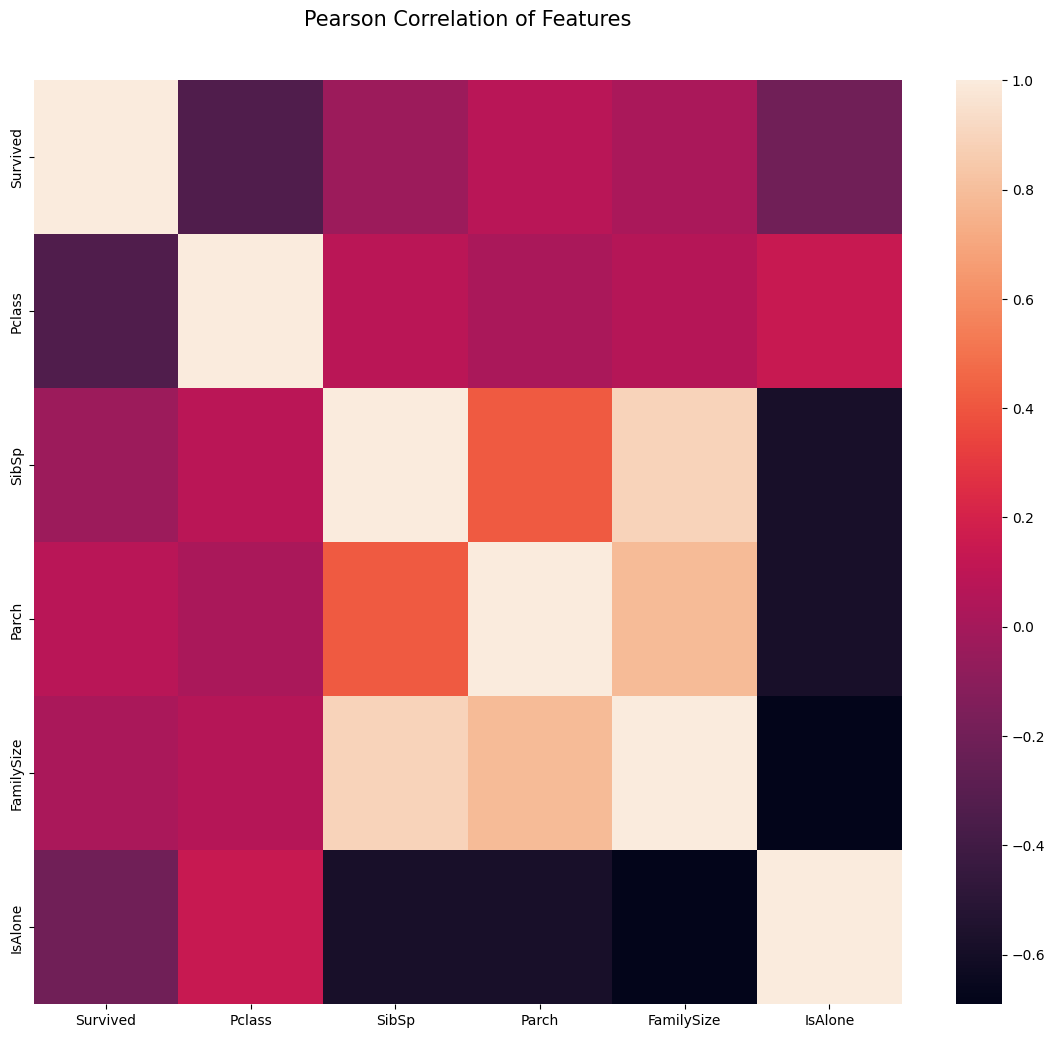

In [273]:
# Select only the numeric columns from df
df_numeric = df.select_dtypes(include=[np.number])

# Now compute the correlation matrix
correlation_matrix = df_numeric.corr()

# Continue with your original code
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_matrix)
plt.show()

## Binarització de les variables categòriques

De cada variables categòrica en farem `m` variables binàries, on `m` és el nombre de categories de la variable.

In [274]:
cols = ['Pclass', 'Embarked', 'FareGroup', 'AgeGroup', 'Title']
titanic_categorical = df[cols]
titanic_categorical = pd.concat([pd.get_dummies(titanic_categorical[col], prefix=col) for col in titanic_categorical], axis=1)
titanic_categorical.head()
df = pd.concat([df[df.columns[~df.columns.isin(cols)]], titanic_categorical], axis=1)
df.head()

,Survived,Sex,SibSp,Parch,FamilySize,IsAlone,InCabin,Pclass_1,Pclass_2,Pclass_3,...,AgeGroup_Teenager,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,True,1,0,2,0,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
1,1,False,1,0,2,0,True,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,1,False,0,0,1,1,False,False,False,True,...,False,False,True,False,False,False,True,False,False,False
3,1,False,1,0,2,0,True,True,False,False,...,False,False,True,False,False,False,False,False,True,False
4,0,True,0,0,1,1,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False


## Conjunts d'entrenament i de test

Dividim les dades en dos conjunts, d'entrenament i de test. Amb el conjunt d'entrenament crearem el model predictiu, i amb el de test, l'avaluarem per veure quin rendiment té.

In [275]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Models predictius

Ara que ja tenim el conjunt de dades preparat per l'anàlisi, crearem diferents models de predicció i els compararem. Els models que crearem seran els següents:

- Regressió logística
- Arbres de decisió
- Random Forests
- k-nearest neigbours
- Support Vectror Machines

Els avaluarem amb la mètrica de l'àrea sota la corba ROC del model de predicció respecte els resultats, i escollirem aquell model que tingui millor resultat.

In [276]:
performance_auc = {}

### Regressió logística

In [277]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
model

LogisticRegression()

In [278]:
predicted = model.predict(X_test)
predicted

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0])

<module 'matplotlib.pyplot' from '/home/codespace/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

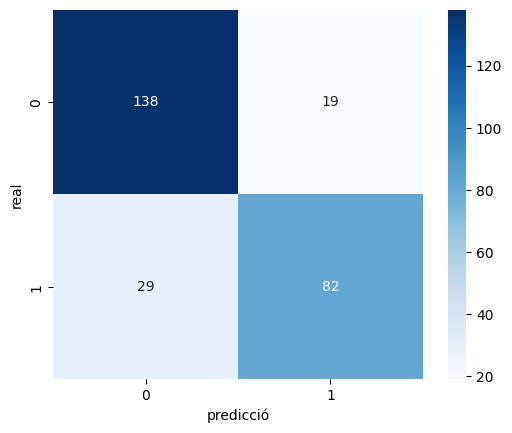

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predicted)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("predicció")
plt.ylabel("real")
plt

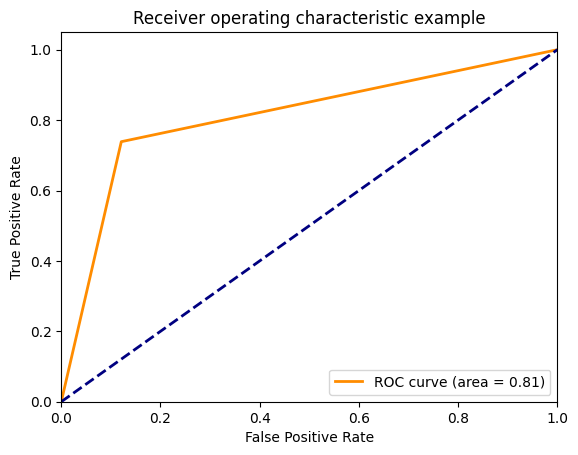

In [280]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)
performance_auc['Logistic Regression'] = roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Arbres de decisió

In [281]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier().fit(X_train, y_train)
model

DecisionTreeClassifier()

In [282]:
predicted = model.predict(X_test)
predicted

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1])

<module 'matplotlib.pyplot' from '/home/codespace/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

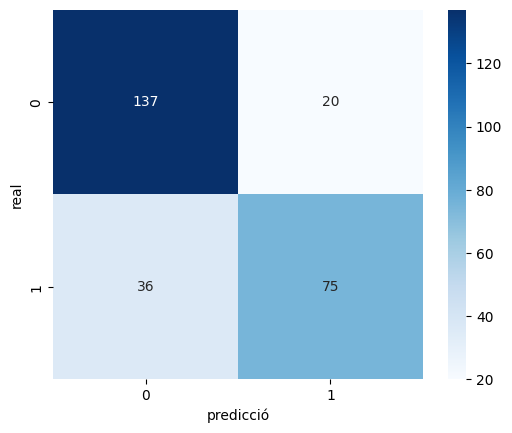

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predicted)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("predicció")
plt.ylabel("real")
plt

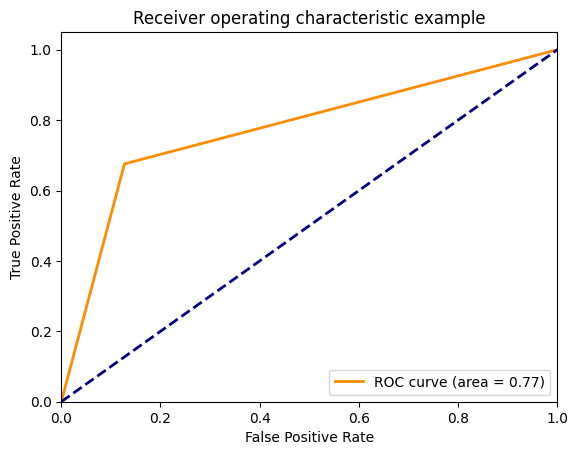

In [284]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)
performance_auc['Decision Tree'] = roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [285]:
pd.concat((pd.DataFrame(X_train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
29,Title_Mrs,0.363961
3,IsAlone,0.114529
8,Embarked_C,0.112726
5,Pclass_1,0.044432
31,NaN,0.044012
19,AgeGroup_Baby,0.032274
9,Embarked_Q,0.030823
24,AgeGroup_Adult,0.029704
12,FareGroup_B,0.025467
25,AgeGroup_Senior,0.024899


### Random Forests

In [286]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(1000).fit(X_train, y_train)
model

RandomForestClassifier(n_estimators=1000)

In [287]:
predicted = model.predict(X_test)
predicted

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1])

<module 'matplotlib.pyplot' from '/home/codespace/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

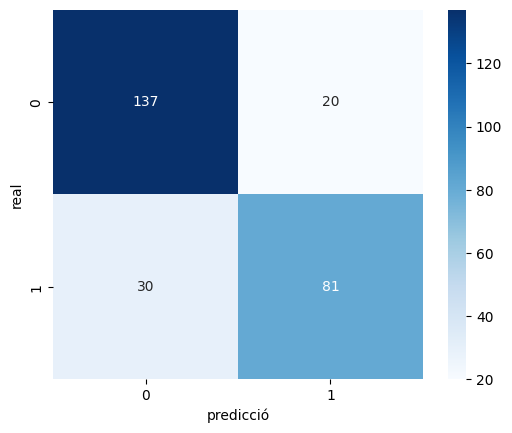

In [288]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predicted)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("predicció")
plt.ylabel("real")
plt

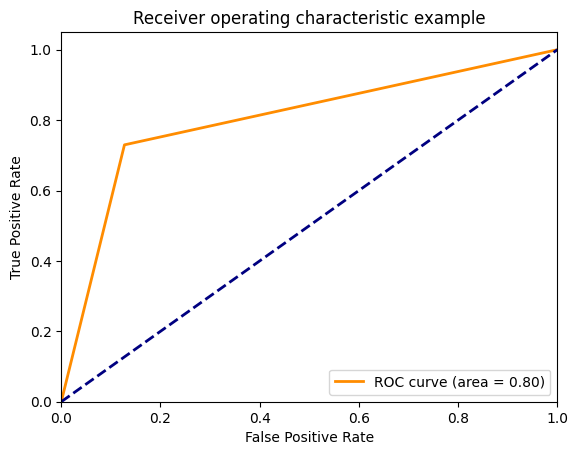

In [289]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)
performance_auc['Random Forests'] = roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [290]:
pd.concat((pd.DataFrame(X_train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
29,Title_Mrs,0.132045
0,SibSp,0.119870
3,IsAlone,0.061786
8,Embarked_C,0.053998
5,Pclass_1,0.050845
30,Title_Rare,0.046449
28,Title_Mr,0.044956
1,Parch,0.038987
2,FamilySize,0.030536
24,AgeGroup_Adult,0.027852


### k-nearest neighbors

In [302]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
model

KNeighborsClassifier(n_neighbors=3)

In [303]:
X_test

,Sex,SibSp,Parch,FamilySize,IsAlone,InCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,...,AgeGroup_Teenager,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
709,True,1,1,3,0,False,False,False,True,True,...,False,False,False,False,False,True,False,False,False,False
439,True,0,0,1,1,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,False
840,True,0,0,1,1,False,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False
720,False,0,1,2,0,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
39,False,1,0,2,0,False,False,False,True,True,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,True,0,0,1,1,False,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False
633,True,0,0,1,1,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
456,True,0,0,1,1,True,True,False,False,False,...,False,False,False,False,True,False,False,True,False,False
500,True,0,0,1,1,False,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False


In [307]:
predicted = model.predict(X_test)
predicted

AttributeError: 'Flags' object has no attribute 'c_contiguous'

<module 'matplotlib.pyplot' from '/home/codespace/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

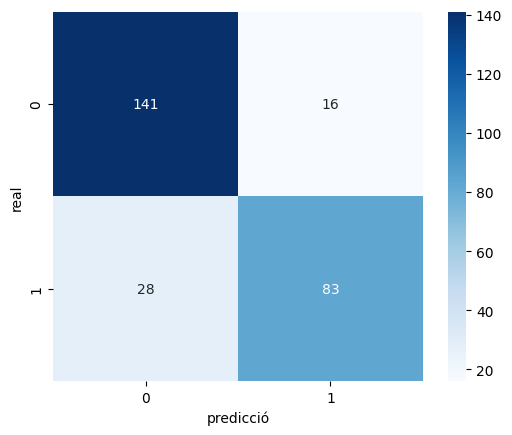

In [308]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predicted)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("predicció")
plt.ylabel("real")
plt

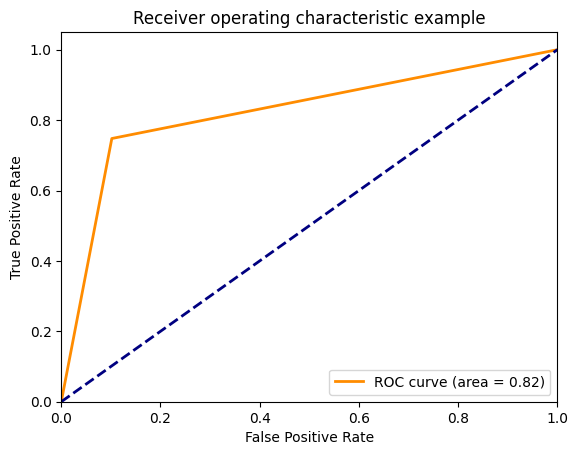

In [309]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)
performance_auc['k-nearest neighbours'] = roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machines

In [310]:
from sklearn.svm import SVC

model = SVC(probability=True).fit(X_train, y_train)
model

SVC(probability=True)

In [311]:
predicted = model.predict(X_test)
predicted

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0])

<module 'matplotlib.pyplot' from '/home/codespace/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

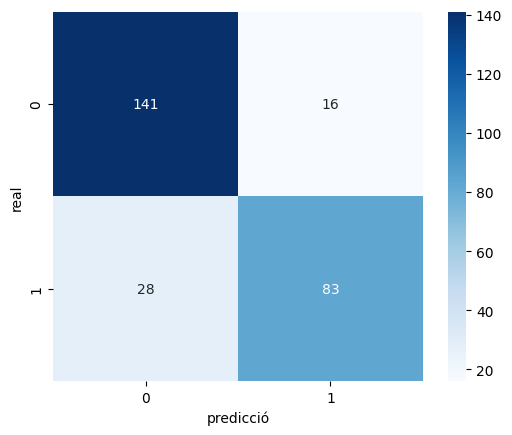

In [312]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predicted)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("predicció")
plt.ylabel("real")
plt

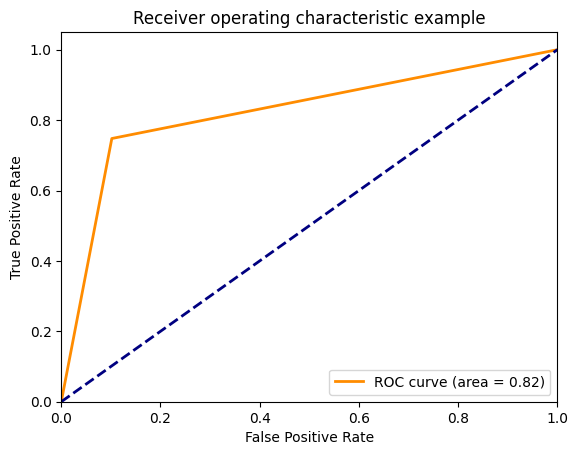

In [313]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)
performance_auc['SVM'] = roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Conclusió

Després d'aplicar diferents models de classificació, i veient que no hi ha massa diferències de rendiment entre ells, el que millor resultat ens ha donat amb la mètrica que hem escollit ha estat el de Support Vector Machines.

<Axes: title={'center': 'Classifier AUC'}, xlabel='AUC', ylabel='Model'>

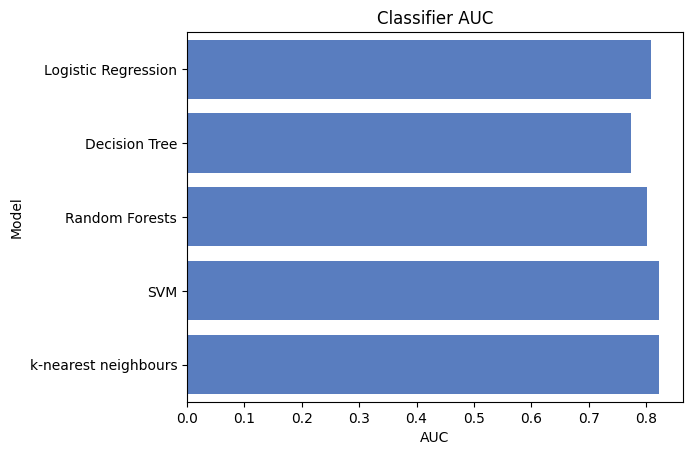

In [314]:
perf = pd.DataFrame.from_dict(performance_auc, orient='index')
perf['Model'] = perf.index
perf['AUC'] = perf[0]
plt.xlabel('AUC')
plt.title('Classifier AUC')
sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Model', data=perf, color="b")

<!--Footer-->
 <div style="background: #333333;padding: 35px 0px;margin-top: 25px;">
    <div class="row">
     <div class="col-sm-12">
        <img src="https://cv.uoc.edu/mc-icons/inici/logoUOC.png" alt="Logo UOC" class="img-responsive" style="margin: 0 auto; display: block;">
    </div>
</div>
</div>
<!--/Footer-->